In [2]:
%matplotlib inline
import matplotlib.pyplot as plot
from IPython import display
from IPython.core.pylabtools import figsize
from __future__ import print_function

# import json
# import matplotlib
# s = json.load(open("../../styles/bmh_matplotlibrc.json"))
# matplotlib.rcParams.update(s)

import os
import sys
import glob
import numpy as np
import numpy.random as nr

import keras
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense, Input, Flatten, Dropout, Lambda
from keras.layers import Conv2D, MaxPooling2D, Embedding
from keras.layers.normalization import BatchNormalization
from keras.models import Model, load_model, Sequential
from keras.optimizers import (SGD, 
                              RMSprop, 
                              Adam, 
                              Adadelta, 
                              Adagrad)

sys.path.append('../src')
from my_keras_utilities import (get_available_gpus, 
                                load_model_and_history, 
                                save_model_and_history, 
                                TrainingPlotter)

os.makedirs('../../models',exist_ok=True)
np.set_printoptions(precision=3, linewidth=120, suppress=True)

In [3]:
import keras.backend as K
K.set_floatx('float32')

print('Backend:        {}'.format(K.backend()))
print('Data format:    {}'.format(K.image_data_format()))
print('Available GPUS:', get_available_gpus())

Backend:        tensorflow
Data format:    channels_last
Available GPUS: []


In [1]:
from keras.datasets import mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.

X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

print('X_train shape:', X_train.shape)

Using TensorFlow backend.


X_train shape: (60000, 784)


In [13]:
def make_trainable(net, val=True):
    net.trainable = val
    for layer in net.layers:
        layer.trainable = val

# Generator
G_in = Input(shape=(100,))
G_h1 = Dense(128, activation='relu')(G_in)
G_out = Dense(784, activation='sigmoid')(G_h1)
G = Model(G_in, G_out)
G.summary()
             
# Discriminator
D_in = Input(shape=(784,))
D_h1 = Dense(128, activation='relu')(D_in)
D_out = Dense(1, activation='sigmoid')(D_h1)
D = Model(D_in, D_out)
D.compile(loss='binary_crossentropy', optimizer=Adam())
D.summary()

N_in = Input(shape=(100,))
N_img = G(N_in)
N_out = D(N_img)
GAN = Model(N_in, N_out)
GAN.compile(loss='binary_crossentropy', optimizer=Adam())
GAN.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 100)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 128)               12928     
_________________________________________________________________
dense_14 (Dense)             (None, 784)               101136    
Total params: 114,064
Trainable params: 114,064
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 784)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 128)               100480    
_________________________________________________________________
dens

In [26]:
losses = dict(g=[], d=[])

def trainIt(nepochs, batch_size=32, pint=10):
    
    for i in range(nepochs):
        
        # Real images
        real_images = X_train[np.random.randint(0, X_train.shape[0], size=batch_size)]
        
        # Fake images
        fake_images = G.predict(np.random.uniform(0, 1, size=[batch_size, 100]))
        
        # Train discriminator these images
        X = np.vstack((real_images, fake_images))
        y = np.zeros([2*batch_size])
        y[:batch_size] = 1
        y[batch_size:] = 0
        
        make_trainable(D, True)
        d_loss  = D.train_on_batch(X, y)
        losses["d"].append(d_loss)
    
        # Train Generator-Discriminator stack on input noise
        noise_tr = np.random.uniform(0, 1, size=[batch_size, 100])
        y2 = np.ones([batch_size])
        
        make_trainable(D, False)
        g_loss = GAN.train_on_batch(noise_tr, y2)
        losses["g"].append(g_loss)
        
        if i%pint == 0:
#             plot_loss(losses)
#             plot_gen()
            print('{:6d}: G_loss = {:.5f};  D_loss = {:.5f}'.format(i, g_loss, d_loss))
            

In [27]:
try:
    trainIt(100000, pint=1000)
except:
    pass

     0: G_loss = 0.21071;  D_loss = 1.01728
  1000: G_loss = 0.21057;  D_loss = 1.01533
  2000: G_loss = 0.21142;  D_loss = 1.03005
  3000: G_loss = 0.21083;  D_loss = 1.03026
  4000: G_loss = 0.21065;  D_loss = 1.01812
  5000: G_loss = 0.21058;  D_loss = 1.01678
  6000: G_loss = 0.21078;  D_loss = 1.01973
  7000: G_loss = 0.21067;  D_loss = 1.01802
  8000: G_loss = 0.21064;  D_loss = 1.01748
  9000: G_loss = 0.21036;  D_loss = 1.01363
 10000: G_loss = 0.21030;  D_loss = 1.01209
 11000: G_loss = 0.21021;  D_loss = 1.01085
 12000: G_loss = 0.21053;  D_loss = 1.01141
 13000: G_loss = 0.20931;  D_loss = 0.99842
 14000: G_loss = 0.20936;  D_loss = 0.99931
 15000: G_loss = 0.20937;  D_loss = 0.99957
 16000: G_loss = 0.20938;  D_loss = 0.99963
 17000: G_loss = 0.20937;  D_loss = 0.99963
 18000: G_loss = 0.20937;  D_loss = 0.99965
 19000: G_loss = 0.20937;  D_loss = 0.99964
 20000: G_loss = 0.20937;  D_loss = 0.99965
 21000: G_loss = 0.20937;  D_loss = 0.99965
 22000: G_loss = 0.20937;  D_los

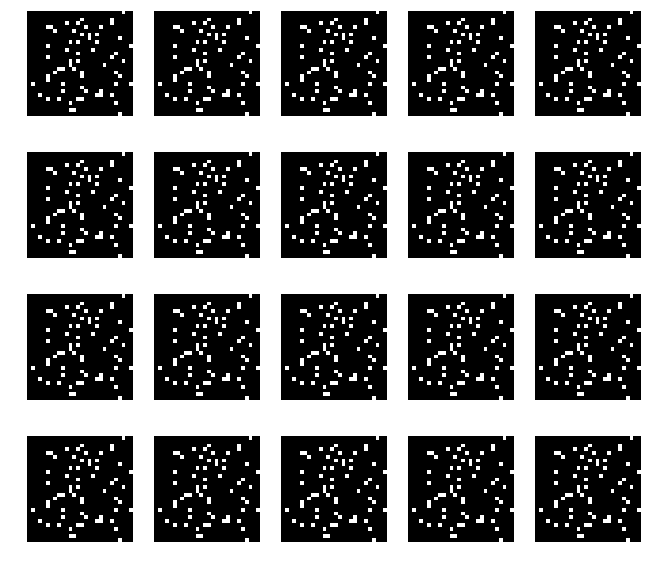

In [28]:
fake_images = G.predict(np.random.uniform(0, 1, size=[20, 100])).reshape(20, 28, 28)

figsize(11, 10)
for i, img in enumerate(fake_images):
    plot.subplot(4, 5, i+1)
    plot.imshow(img, cmap=plot.cm.gray)
    plot.axis('off')    
